<a href="https://colab.research.google.com/github/vincenzo-esposit0/horizon2020/blob/main/ReteNeurale_VincenzoEsposito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from haversine import haversine, Unit
%matplotlib inline

In [ ]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

In [ ]:
# Funzione per la detenzione di percorsi che non sono ammessi
def detection(path, soglia):
  no_path = [] #Percorsi non ammessi
  ok_path = [] #Percorsi ammessi
  index = 0
  clusters = rs[['latitude', 'longitude']].to_numpy()
  path = df[['latitude', 'longitude']].to_numpy()
  for p in path:
    min_dist = 100
    for i in clusters:
      distance = haversine(p, i, unit=Unit.METERS)
      if(distance < min_dist):
        min_dist = distance
    if(min_dist >= soglia):
      no_path.append(index)
    else:
      ok_path.append(index)
    index += 1

  path_labels = [i for i in range(path.size)]
  ok_path_df = pd.DataFrame(path[ok_path], columns=['latitude', 'longitude'])
  no_path_df = pd.DataFrame(path[no_path], columns=['latitude', 'longitude'])

  fig, ax = plt.subplots(figsize=[10, 6])
  ok_scatter = ax.scatter(ok_path_df['longitude'], ok_path_df['latitude'], c='#1f77b4', edgecolor='None', alpha=0.7, s=120)
  no_scatter = ax.scatter(no_path_df['longitude'], no_path_df['latitude'], c='#e377c2', edgecolor='None', alpha=0.7, s=120)
  path_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.9, s=3)
  ax.set_title('Path analysis')
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')
  ax.legend([path_scatter, no_scatter, ok_scatter], ['Full path', 'Not on path', 'On path'], loc='upper left')
  plt.show()

In [ ]:
# Costruisco il DataFrame tramite il DataSet di Training
df = pd.read_excel (r'gdrive/My Drive/Training/gps_tracker_gps_data_22July_porto.xlsx')
df.to_csv (r'gdrive/My Drive/training.csv', index = None, header=True)

df.head()

,head,mode,imei,ip,port,data_type,satellite_n,timestamp_utc,timestamp_utc_ms,date_local,latitude,longitude,speed,heading,event_id,voltage,sequence_number
0,MT,6,867035047588320,83.48.128.250,1750,R0,6,2021-07-22 07:36:32,1626939392000,2021-07-22,39.45420,-0.32866,0.00,0,20,3.693,3
1,MT,6,867035047588320,176.82.194.138,1750,R0,6,2021-07-22 07:37:06,1626939426000,2021-07-22,39.45473,-0.32890,28.15,32,2,3.693,2
2,MT,6,867035047588320,176.82.194.138,1750,R0,6,2021-07-22 07:37:16,1626939436000,2021-07-22,39.45532,-0.32874,26.48,313,2,3.693,3
3,MT,6,867035047588320,176.82.194.138,1750,R0,6,2021-07-22 07:37:26,1626939446000,2021-07-22,39.45505,-0.32931,30.92,179,2,3.693,4
4,MT,6,867035047588320,176.82.194.138,1750,R0,9,2021-07-22 07:37:36,1626939456000,2021-07-22,39.45433,-0.32921,27.96,180,2,3.693,5


In [ ]:
# Estraggo le cordinate dal DataFrame e creo un array numpy
coords = df[['latitude', 'longitude']].to_numpy()

# Definisco un epsilon che verrà utilizzata all'interno dell'algoritmo DBSCAN
epsilon = 0.001 / kms_per_radian

In [ ]:
start_time = time.time()

# Algoritmo DBSCAN
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_

# Restituisce il numero di cluster trovati
num_clusters = len(set(cluster_labels))

# Messaggio di conferma di creazione dei cluster
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))

# Accuratezza dei cluster
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 76 points down to 181 clusters, for -138.2% compression in 0.01 seconds
Silhouette coefficient: 0.011


In [ ]:
# Trasforma i gruppi in una serie di pandas, dove ogni elemento è un gruppo di punti
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [ ]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [ ]:
# Decomprime l'elenco delle tuple dei punti più centrali (lat, lon) in elenchi separati di lat e lon
lats, lons = zip(*centermost_points)

# Dai dati di lats/lons crea un nuovo DataFrame di un punto rappresentativo per ogni cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

In [ ]:
# Estraggo la riga dal set di dati originali in cui lat/lon corrisponde alla lat/lon di ciascuna riga dei punti rappresentativi
rs = rep_points.apply(lambda row: df[(df['latitude']==row['lat']) & (df['longitude']==row['lon'])].iloc[0], axis=1)
rs.to_csv('gdrive/My Drive/DBSCAN.csv', encoding='utf-8')
rs.tail()

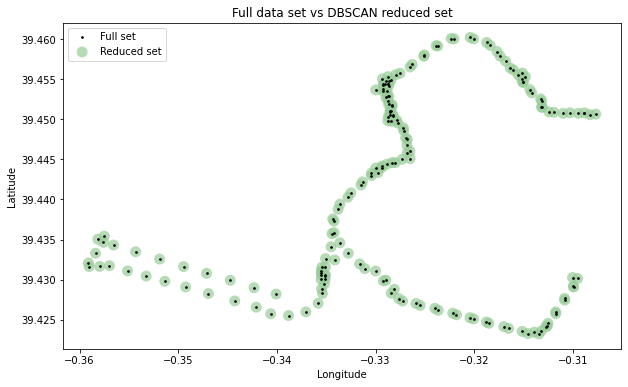

In [ ]:
# Mostro l'insieme di cluster che indicano il percorso ammesso
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper left')
plt.show()

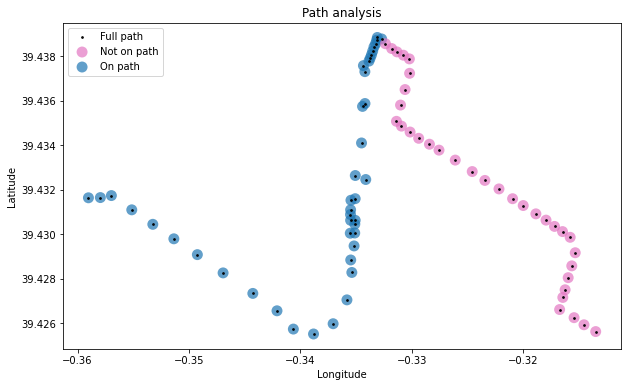

In [ ]:
# Percorso di test 1
df = pd.read_excel (r'gdrive/My Drive/Test/gps_tracker_22JulyDOS.xlsx')
df.to_csv (r'gdrive/My Drive/test.csv', index = None, header=True)

# Prende il percorso e la soglia
detection(df, 100)

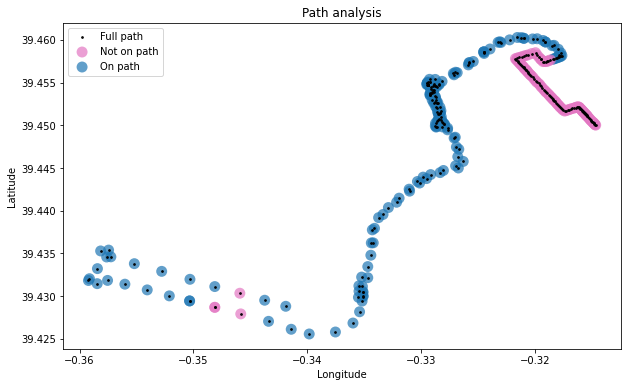

In [ ]:
# Percorso di test 2
df = pd.read_excel (r'gdrive/My Drive/Test/gps_tracker_23JulyDOS.xlsx')
df.to_csv (r'gdrive/My Drive/test.csv', index = None, header=True)

# Prende il percorso e la soglia
detection(df, 100)

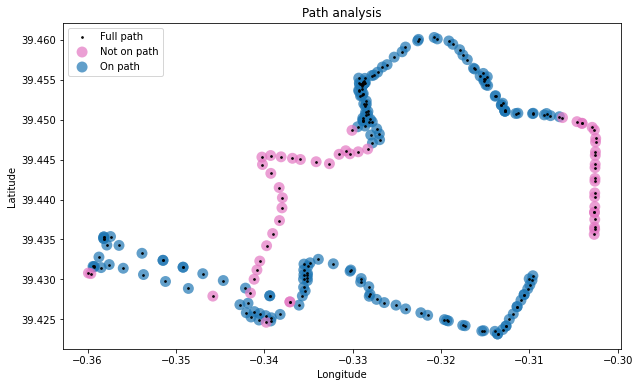

In [ ]:
# Percorso di test 3
df = pd.read_excel (r'gdrive/My Drive/Test/gps_tracker_29JulyDOS.xlsx')
df.to_csv (r'gdrive/My Drive/test.csv', index = None, header=True)

# Prende il percorso e la soglia
detection(df, 100)